In [3]:
import pandas as pd
df = pd.read_csv('customers.csv')
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicatessen      440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [ ]:
# 1. 이상치 제거
def remove_outlier_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.025)
        Q3 = df[col].quantile(0.975)
        IQR = Q3- Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[ (df[col] <= upper) & (df[col] >= lower)]
    return df
numeric_cols = df.select_dtypes(include = 'number').columns
df_clean = remove_outlier_iqr(df, numeric_cols)

In [18]:
numeric_cols = df.select_dtypes(include = 'number').columns
df_clean = remove_outlier_iqr(df, numeric_cols)

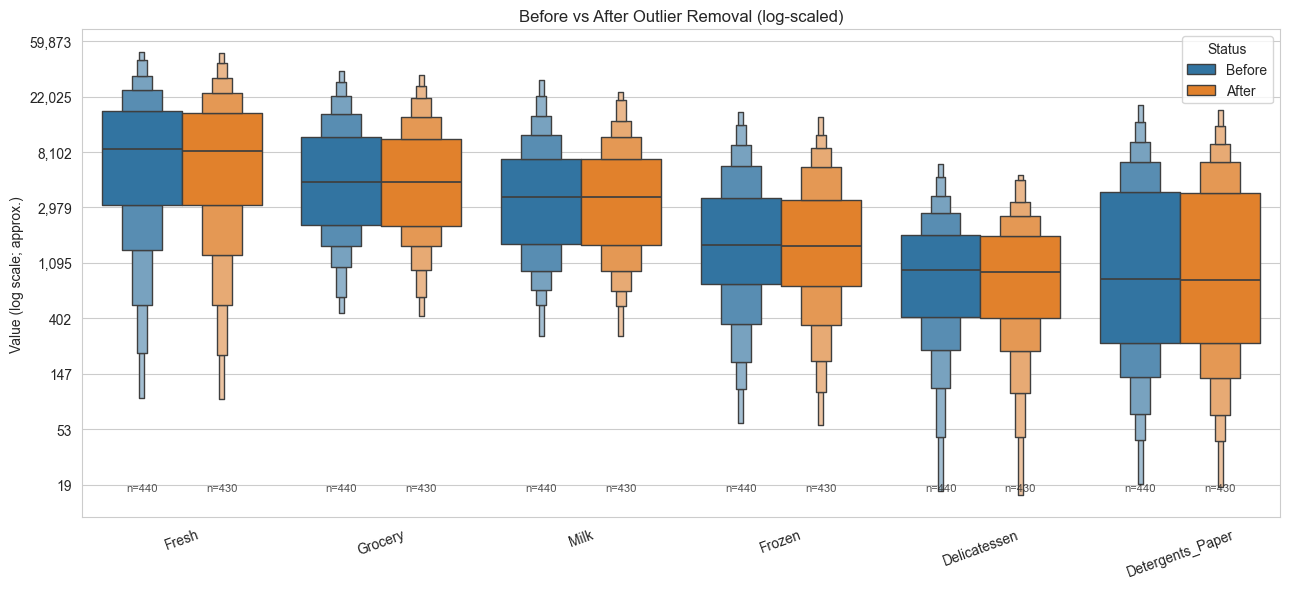

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# 1) 수치형만 취하고, 코드형 변수는 제외(원하시면 리스트 수정)
exclude = {'Channel', 'Region'}
num_cols = [c for c in numeric_cols if c not in exclude]

df_before = df[num_cols].copy()
df_before['Status'] = 'Before'

df_after = df_clean[num_cols].copy()
df_after['Status'] = 'After'

df_long = pd.concat([df_before, df_after], ignore_index=True)
df_long = df_long.melt(id_vars='Status', var_name='Variable', value_name='Value')

# 2) 로그 스케일용 변환 (0 처리 위해 log1p)
df_long['Value_log'] = np.log1p(df_long['Value'])

# 3) 변수 정렬: Before 중앙값 기준 내림차순
order = (
    df_long[df_long['Status'] == 'Before']
    .groupby('Variable')['Value_log']
    .median()
    .sort_values(ascending=False)
    .index.tolist()
)

# 4) 플로팅
plt.figure(figsize=(13, 6))
sns.set_style("whitegrid")

# boxenplot: 분포 모양을 더 잘 보여줌
ax = sns.boxenplot(
    data=df_long,
    x='Variable', y='Value_log', hue='Status',
    order=order, showfliers=False, linewidth=1
)

# y축을 원래 단위처럼 보이게 라벨 포맷 (log1p 역변환 느낌)
ax.set_ylabel('Value (log scale; approx.)')
ax.set_xlabel('')
ax.set_title('Before vs After Outlier Removal (log-scaled)')

# 천단위 포맷: expm1 후 반올림해서 표시
def inv_log1p_formatter(y, _):
    return f"{int(np.expm1(y)):,}"
ax.yaxis.set_major_formatter(FuncFormatter(inv_log1p_formatter))

plt.xticks(rotation=20)

# 범례 위쪽으로
ax.legend(title='Status', loc='upper right', frameon=True)

# 5) 각 변수·상태별 표본 수 n 표시
counts = (df_long
          .dropna(subset=['Value_log'])
          .groupby(['Variable', 'Status']).size())

# 박스 중앙에 n 텍스트 (대략적인 위치)
for i, var in enumerate(order):
    for j, status in enumerate(['Before', 'After']):
        n = counts.get((var, status), 0)
        ax.text(
            i + (-0.2 if status == 'Before' else 0.2),   # 살짝 좌/우로
            ax.get_ylim()[0] + 0.05*(ax.get_ylim()[1]-ax.get_ylim()[0]),
            f"n={n}", ha='center', va='bottom', fontsize=8, alpha=0.8
        )

plt.tight_layout()
plt.show()
